In [1]:
import copy
import glob
import os
import time

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from arguments import get_args
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.vec_normalize import VecNormalize
#from envs import make_env
from model import Policy
from storage import RolloutStorage
#from visualize import visdom_plot
import matplotlib.pyplot as plt
import algo

import os

import gym
import numpy as np
from gym.spaces.box import Box

from baselines import bench
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

In [2]:
add_timestep = False
algorithm = 'a2c'
alpha = 0.99
clip_param=0.2
cuda = True
entropy_coef=0.01
#env_name = "PongNoFrameskip-v4"
env_name  = "BreakoutNoFrameskip-v4"
eps=1e-05
gamma=0.99
log_dir='gym'
log_interval = 10
lr = 0.0007
max_grad_norm=0.5
no_cuda=False
no_vis=False
num_frames=10000000.0
num_mini_batch=32
num_processes=1
num_stack=4
num_steps=5
port=8097
ppo_epoch=4
recurrent_policy=False
save_dir='trained_models'
save_interval=1000
seed=1
tau=0.95
use_gae=False
value_loss_coef=0.5
vis=True
vis_interval=100




In [3]:
class AddTimestep(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(AddTimestep, self).__init__(env)
        self.observation_space = Box(
            self.observation_space.low[0],
            self.observation_space.high[0],
            [self.observation_space.shape[0] + 1],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return np.concatenate((observation, [self.env._elapsed_steps]))


class WrapPyTorch(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(WrapPyTorch, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

In [4]:
def make_env(env_id, seed, rank, log_dir, add_timestep):
    
    def _thunk():
        if env_id.startswith("dm"):
            _, domain, task = env_id.split('.')
            env = dm_control2gym.make(domain_name=domain, task_name=task)
        else:
            env = gym.make(env_id)
        
        
        is_atari = hasattr(gym.envs, 'atari') and isinstance(
            env.unwrapped, gym.envs.atari.atari_env.AtariEnv)
        if is_atari:
            env = make_atari(env_id)
        env.seed(seed + rank)

        obs_shape = env.observation_space.shape
        if add_timestep and len(
                obs_shape) == 1 and str(env).find('TimeLimit') > -1:
            env = AddTimestep(env)

        #if log_dir is not None:
        #    env = bench.Monitor(env, os.path.join(log_dir, str(rank)))

        logging_interval = 50
        VISUALIZE = True
        if not os.path.exists('video'):
            os.makedirs('video')
        if VISUALIZE:
            if not os.path.exists('video' + '/' + env_id):
                os.mkdir('video' + '/' + env_id)
            env = gym.wrappers.Monitor(env, 'video' + '/' + env_id, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)

        #env.reset()
        #env.render()    
            
            
        if is_atari:
            env = wrap_deepmind(env)

        # If the input has shape (W,H,3), wrap for PyTorch convolutions
        obs_shape = env.observation_space.shape
        if len(obs_shape) == 3 and obs_shape[2] in [1, 3]:
            env = WrapPyTorch(env)

        return env

    return _thunk


In [5]:
if not os.path.exists('npy'):
    os.makedirs('npy')
if not os.path.exists('plot'):
    os.makedirs('plot')

In [6]:
assert algorithm in ['a2c', 'ppo', 'acktr']
if recurrent_policy:
    assert algorithm in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'

In [7]:
num_updates = int(num_frames) // num_steps // num_processes
print(num_updates)

2000000


In [8]:
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [9]:
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)

In [10]:
print("#######")
print("WARNING: All rewards are clipped or normalized so you need to use a monitor (see envs.py) or visdom plot to get true rewards")
print("#######")

#######
#######


In [11]:
'''
torch.set_num_threads(1)
if vis:
    from visdom import Visdom
    viz = Visdom(port=port)
    win = None
'''

'\ntorch.set_num_threads(1)\nif vis:\n    from visdom import Visdom\n    viz = Visdom(port=port)\n    win = None\n'

In [12]:
print(num_processes)
envs = [make_env(env_name, seed, i, log_dir, add_timestep)
            for i in range(num_processes)]
print(envs[0])

1
<function make_env.<locals>._thunk at 0x7f288638a6a8>


In [13]:
if num_processes > 1:
    envs = SubprocVecEnv(envs)
else:
    envs = DummyVecEnv(envs)


In [14]:
if len(envs.observation_space.shape) == 1:
        envs = VecNormalize(envs)

In [15]:
obs_shape = envs.observation_space.shape
obs_shape = (obs_shape[0] * num_stack, *obs_shape[1:])

In [16]:
actor_critic = Policy(obs_shape, envs.action_space, recurrent_policy)

In [17]:
if envs.action_space.__class__.__name__ == "Discrete":
    action_shape = 1
else:
    action_shape = envs.action_space.shape[0]

In [18]:
if cuda:
    actor_critic.cuda()


if algorithm == 'a2c':
    agent = algo.A2C_ACKTR(actor_critic, value_loss_coef,
                           entropy_coef, lr=lr,
                           eps=eps, alpha=alpha,
                           max_grad_norm=max_grad_norm)
elif algorithm == 'ppo':
    agent = algo.PPO(actor_critic, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, lr=lr,
                           eps=eps,
                           max_grad_norm=max_grad_norm)
elif algorithm == 'acktr':
    agent = algo.A2C_ACKTR(actor_critic, value_loss_coef,
                           entropy_coef, acktr=True)


In [19]:
rollouts = RolloutStorage(num_steps, num_processes, obs_shape, envs.action_space, actor_critic.state_size)
current_obs = torch.zeros(num_processes, *obs_shape)

In [20]:
def update_current_obs(obs):
    shape_dim0 = envs.observation_space.shape[0]
    obs = torch.from_numpy(obs).float()
    if num_stack > 1:
        current_obs[:, :-shape_dim0] = current_obs[:, shape_dim0:]
    current_obs[:, -shape_dim0:] = obs

In [21]:
obs = envs.reset()
envs.render()
update_current_obs(obs)
rollouts.observations[0].copy_(current_obs)

tensor([[[[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          ...,
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.]],

         [[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          ...,
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.]],

         [[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          ...,
          [   0.,    0.,    0.,  ...,    0.,    0.,

In [22]:
# These variables are used to compute average rewards for all processes.
episode_rewards = torch.zeros([num_processes, 1])
final_rewards = torch.zeros([num_processes, 1])

In [23]:
if cuda:
    current_obs = current_obs.cuda()
    rollouts.cuda()

Updates 0, num timesteps 5, FPS 14, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38501, value loss 0.00001, policy loss -0.00387


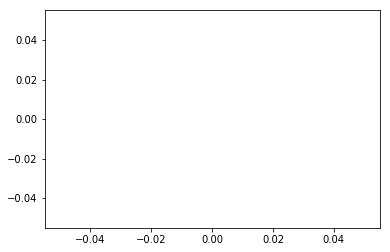

Updates 10, num timesteps 55, FPS 69, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38499, value loss 0.00149, policy loss -0.02411
Updates 20, num timesteps 105, FPS 103, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38533, value loss 0.00002, policy loss -0.00552
Updates 30, num timesteps 155, FPS 124, mean/median reward 1.0/1.0, min/max reward 1.0/1.0, entropy 1.38536, value loss 0.58316, policy loss 0.79755
Updates 40, num timesteps 205, FPS 138, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38481, value loss 0.00001, policy loss -0.00406
Updates 50, num timesteps 255, FPS 153, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38409, value loss 0.00003, policy loss -0.00679
Updates 60, num timesteps 305, FPS 164, mean/median reward 0.0/0.0, min/max reward 0.0/0.0, entropy 1.38424, value loss 0.00002, policy loss -0.00573
Updates 70, num timesteps 355, FPS 172, mean/median reward 1.0/1.0, min/max reward 1.0/1.0, entropy 1.3

KeyboardInterrupt: 

In [29]:
start = time.time()
reward_mean_arr = []

for j in range(num_updates):
    for step in range(num_steps):
        
        if j % save_interval == 0 :
            envs.render()
            time.sleep(0.05)
        
        
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, states = actor_critic.act(
                    rollouts.observations[step],
                    rollouts.states[step],
                    rollouts.masks[step])
        cpu_actions = action.squeeze(1).cpu().numpy()

        # Obser reward and next obs
        obs, reward, done, info = envs.step(cpu_actions)
        reward = torch.from_numpy(np.expand_dims(np.stack(reward), 1)).float()
        episode_rewards += reward

        # If done then clean the history of observations.
        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        final_rewards *= masks
        final_rewards += (1 - masks) * episode_rewards
        episode_rewards *= masks

        if cuda:
            masks = masks.cuda()

        if current_obs.dim() == 4:
            current_obs *= masks.unsqueeze(2).unsqueeze(2)
        else:
            current_obs *= masks

        update_current_obs(obs)
        rollouts.insert(current_obs, states, action, action_log_prob, value, reward, masks)

    with torch.no_grad():
        next_value = actor_critic.get_value(rollouts.observations[-1],
                                            rollouts.states[-1],
                                            rollouts.masks[-1]).detach()

    rollouts.compute_returns(next_value, use_gae, gamma, tau)

    value_loss, action_loss, dist_entropy = agent.update(rollouts)

    rollouts.after_update()

    if j % save_interval == 0 and save_dir != "":
        save_path = os.path.join(save_dir, algorithm)
        try:
            os.makedirs(save_path)
        except OSError:
            pass

        # A really ugly way to save a model to CPU
        save_model = actor_critic
        if cuda:
            save_model = copy.deepcopy(actor_critic).cpu()

        #save_model = [save_model,
        #                hasattr(envs, 'ob_rms') and envs.ob_rms or None]

        torch.save(save_model, os.path.join(save_path, env_name + ".pt"))

    if j % log_interval == 0:
        end = time.time()
        total_num_steps = (j + 1) * num_processes * num_steps
        print("Updates {}, num timesteps {}, FPS {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}, entropy {:.5f}, value loss {:.5f}, policy loss {:.5f}".
            format(j, total_num_steps,
                   int(total_num_steps / (end - start)),
                   final_rewards.mean(),
                   final_rewards.median(),
                   final_rewards.min(),
                   final_rewards.max(), dist_entropy,
                   value_loss, action_loss))
        
        reward_mean_arr.append(np.asscalar(final_rewards.mean().cpu().data.numpy()))
    
    #print(final_rewards.shape)
    
    if vis and j % save_interval == 0:
        
        np.save('npy/reward_mean_' + str(j)+ '.npy' , np.asarray(reward_mean_arr))
        plt.plot(reward_mean_arr)
        plt.savefig('plot/reward_mean_' + str(j)+ '.png')
        plt.show()